# MLP 多層パーセプトロン

In [188]:
import numpy as np

class MLPClassifier:
    """
    多層パーセプトロン（MLP）による分類器
    - 隠れ層の活性化関数：シグモイド関数 / 双曲線正接関数 / LeRU 関数
    - 出力層の活性化関数：ソフトマックス関数
    
    Attributes
    ----------
    h_layers : int
        隠れ層の数
    h_units : int
        隠れ層のユニットの個数（バイアスを除く）
    epochs : int
        繰り返し回数
    eta : float
        学習率
    n_batch : int
        ミニバッチ学習のバッチサイズ
    l2 : float
        L2正則化の強さ（ラムダパラメータ）
    n : int
        教師データの件数
    m : inti
        入力の次元
    t : int
        分類ラベルの種類数
    W : list[numpy array]
        各層の重み行列を格納する配列
        - 入力層 -> 隠れ層の重み (h x (m+1))
        - 隠れ層 -> 隠れ層の重み (h x (h+1))
        - 隠れ層 -> 出力層の重み (t x (h+1))
    mse : list[float]
        エポック毎の平均二乗誤差（Mean Squared Errors）を格納するリスト
    cost : list[float]
        エポック毎のコスト関数の値を格納するリスト
    mode : string
        隠れ層の活性化関数の種類
    activation : method
        隠れ層の活性化関数
    debug_grad : bool
        True の場合は勾配チェックを行う
    debug_activation_hist : bool
        True の場合は各ステップ・各隠れ層の出力のヒストグラムを計算する
    grad_relative_err : list[float]
        勾配チェックの結果（相対誤差）を格納するリスト
    A_hist : list[list[numpy.histogram]]
        各ステップ・各隠れ層の出力のヒストグラムを格納するリスト
    """
    
    def __init__(self, h_layers, h_units, epochs, eta, n_batch, l2=1.0, mode='tanh', debug_grad=False, debug_activation_hist=False):
        self.h_layers = h_layers
        self.h_units = h_units
        self.epochs = epochs
        self.eta = eta
        self.n_batch = n_batch
        self.l2 = l2
        self.debug_grad = debug_grad
        self.debug_activation_hist = debug_activation_hist
        self.grad_relative_err = []
        self.A_hist = []
        activation_functions = {
            'sigmoid': ActivationFuncSigmoid(),
            'tanh': ActivationFuncHyperbolicTangent(),
            'relu': ActivationFuncReLU()
        }
        if mode in activation_functions:
            self.mode = mode
            self.activation = activation_functions[mode]
        else:
            raise Exception('Mode \'{}\' does not exist.\nAvailable modes: {}'.format(', '.join(activation_functions.keys())))
    
    def fit(self, data, labels):
        self.index2label = np.unique(labels)
        self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        self.n = len(data)
        self.m = len(data[0])
        self.t = len(self.index2label)
        
        self.__initialize_weight()
        
        X = np.full([self.m+1, self.n], 1.0)
        X[1:] = data.T
        Y = np.zeros([self.t, self.n])
        for i in range(self.n):
            l = labels[i]
            Y[self.label2index[l]][i] = 1.0
        
        self.mse = []
        self.cost = []
        for _ in range(self.epochs):
            # ミニバッチ法による学習
            ids = np.random.choice(range(self.n), self.n_batch, replace=False)
            X_part = X[:, ids]
            Y_part = Y[:, ids]
            A, Z = self.__forward_prop(X_part, self.W)
            mse = np.sum((Y_part - A[-1])**2) / self.n_batch
            self.mse.append(mse)
            cost = self.__cost(Y_part, A[-1], self.W)
            self.cost.append(cost)
            if mse < 0.001:
                break
            self.__back_prop(A, Z, X_part, Y_part)
        return
        
    def predict(self, d):
        """
        Parameters
        ----------
        d : 予測したいデータ
        """
        x = np.full(len(d)+1, 1.0)
        x[1:] = d
        y = self.__forward_prop(x.reshape(-1,1), self.W)[0][-1]
        i_label = np.argmax(y)
        return self.index2label[i_label]
    
    def __forward_prop(self, X, W):
        """
        順伝播法により各層の出力を計算
        """
        n = len(X[0])
        A = [X]
        Z = []
        for i in range(self.h_layers):
            Z.append(np.dot(W[i], A[i]))
            A.append(np.full([self.h_units+1, n], 1.0))
            A[-1][1:] = self.activation.phi(Z[-1])
        Z.append(np.dot(W[-1], A[-1]))
        A.append(self.__softmax(Z[-1]))
        if self.debug_activation_hist:
            self.A_hist.append([])
            for A_ in A[1:-1]:
                self.A_hist[-1].append(np.histogram(A_[1:], bins=20))
        return A, Z
    
    def __back_prop(self, A, Z, X, Y):
        """
        誤差逆伝播法により重みを更新
        """
        d = self.__differentiate_cost_by_z(Y, A[-1])
        grad = [np.dot(d, A[-2].T)]
        for i in range(1, self.h_layers+1):
            d = np.dot(self.W[-i].T[1:], d) * self.activation.grad(Z[-i-1])
            grad.append(np.dot(d, A[-i-2].T))
        grad.reverse()
        for i in range(len(grad)):
             grad[i] += self.l2 * self.W[i]
        if self.debug_grad:
            self.__gradient_check(X, Y, self.W, grad)
        # 正則化項の勾配
        for i in range(self.h_layers+1):
            self.W[i] -= self.eta * grad[i]
        return
    
    def __softmax(self, z):
        exp = np.exp(z)
        return exp / np.sum(exp, axis=0)
    
    def __cost(self, Y, Y_pred, W):
        """
        コスト関数を計算する
        具体的には、実現確率（対数尤度）にマイナスをかけたもの
        """
        cost = np.sum(-Y * np.log(Y_pred) - (1.0-Y) * np.log(1.0-Y_pred))
        # 正則化項
        for l in range(len(W)):
            cost += np.sum(W[l]**2) * self.l2 / 2.0
        return cost
    
    def __differentiate_cost_by_z(self, Y, Y_pred):
        tmp = (Y_pred - Y) / (1 - Y_pred)
        d = tmp - Y_pred * np.sum(tmp, axis=0)
        return d
    
    def __initialize_weight(self):
        self.W = []
        if self.mode == 'relu':
            self.W.append(np.random.normal(loc=0, scale=np.sqrt(2.0/(self.m+1)), size=(self.h_units, self.m+1)))
            for i in range(self.h_layers-1):
                self.W.append(np.random.normal(loc=0, scale=np.sqrt(2.0/(self.h_units+1)), size=(self.h_units, self.h_units+1)))
            self.W.append(np.random.normal(loc=0, scale=np.sqrt(2.0/(self.h_units+1)), size=(self.t, self.h_units+1)))
        elif self.mode == 'sigmoid' or self.mode == 'tanh':
            self.W.append(np.random.normal(loc=0, scale=np.sqrt(1.0/(self.m+1)), size=(self.h_units, self.m+1)))
            for i in range(self.h_layers-1):
                self.W.append(np.random.normal(loc=0, scale=np.sqrt(1.0/(self.h_units+1)), size=(self.h_units, self.h_units+1)))
            self.W.append(np.random.normal(loc=0, scale=np.sqrt(1.0/(self.h_units+1)), size=(self.t, self.h_units+1)))
        else:
            self.W.append(np.random.rand(self.h_units, self.m+1))
            for i in range(self.h_layers-1):
                self.W.append(np.random.rand(self.h_units, self.h_units+1))
            self.W.append(np.random.rand(self.t, self.h_units+1))
        
    def __gradient_check(self, X, Y, W, grad):
        """
        デバッグ用のメソッド
        数値的に求めた勾配と解析的に求めた勾配を比べる
        相対誤差（relative_err）が小さい（ゼロに近い）ほど良い
        """
        ep = 1e-5
        num_grad = []
        for i in range(len(W)):
            g = np.zeros(W[i].shape)
            ep_arr = np.zeros(W[i].shape)
            for j in range(W[i].shape[0]):
                for k in range(W[i].shape[1]):
                    ep_arr[j][k] = ep
                    W_ = [np.copy(w) for w in W]
                    W_[i] += ep_arr
                    A, Z = self.__forward_prop(X, W_)
                    cost1 = self.__cost(Y, A[-1], W_)
                    W_ = [np.copy(w) for w in W]
                    W_[i] -= ep_arr
                    A, Z = self.__forward_prop(X, W_)
                    cost2 = self.__cost(Y, A[-1], W_)
                    g[j][k] = (cost1-cost2)/ep/2.0
                    ep_arr[j][k] = 0
            num_grad.append(g)
        v_num_grad= np.hstack(tuple([g.flatten() for g in num_grad]))
        v_grad = np.hstack(tuple([g.flatten() for g in grad]))
        relative_err = np.linalg.norm(v_num_grad-v_grad) / (np.linalg.norm(v_num_grad) + np.linalg.norm(v_grad))
        self.grad_relative_err.append(relative_err)


class ActivationFuncSigmoid:
    def phi(self, z):
        return 1.0 / (1.0 + np.exp(-z))
        
    def grad(self, z):
        sig = self.phi(z)
        return sig * (1.0 - sig)
    
class ActivationFuncHyperbolicTangent:
    def phi(self, z):
        return np.tanh(z)
        
    def grad(self, z):
        cosh = np.cosh(z)
        return 1.0 / cosh**2
        
class ActivationFuncReLU:
    def phi(self, z):
        ret = np.zeros(z.shape)
        i_x_arr, i_y_arr = np.where(z > 0)
        for i_x, i_y in zip(i_x_arr, i_y_arr):
            ret[i_x][i_y] = z[i_x][i_y]
        return ret
        
    def grad(self, z):
        ret = np.zeros(z.shape)
        i_x_arr, i_y_arr = np.where(z > 0)
        for i_x, i_y in zip(i_x_arr, i_y_arr):
            ret[i_x][i_y] = 1.0
        return ret

In [189]:
import numpy
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

def plot(classifier, data, labels, title=None, xlabel=None, ylabel=None):
    unique_labels = np.unique(labels)
    colors = ['red', 'blue', 'green', 'orange', 'cyan'][:len(unique_labels)]
    x1max, x1min = np.max(data[:, 0]), np.min(data[:, 0])
    x2max, x2min = np.max(data[:, 1]), np.min(data[:, 1])
    scale_x1 = x1max - x1min
    scale_x2 = x2max - x2min
    x1max, x1min = x1max + (x1max-x1min)*0.05, x1min - (x1max-x1min)*0.05
    x2max, x2min = x2max + (x2max-x2min)*0.05, x2min - (x2max-x2min)*0.05
    resolution = scale_x1 / 200
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, resolution), np.arange(x2min, x2max, resolution))
    z = np.array([classifier.predict(x) for x in np.array([xx1.ravel(), xx2.ravel()]).T])
    z = z.reshape(xx1.shape)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=ListedColormap(colors))
    
    data_of_each_label = {}
    for d, l in zip(data, labels):
        if l in data_of_each_label:
            data_of_each_label[l].append(d)
        else:
            data_of_each_label[l] = [d]
    
    for i in range(len(unique_labels)):
        data = data_of_each_label[unique_labels[i]]
        plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], s=5, c=colors[i])

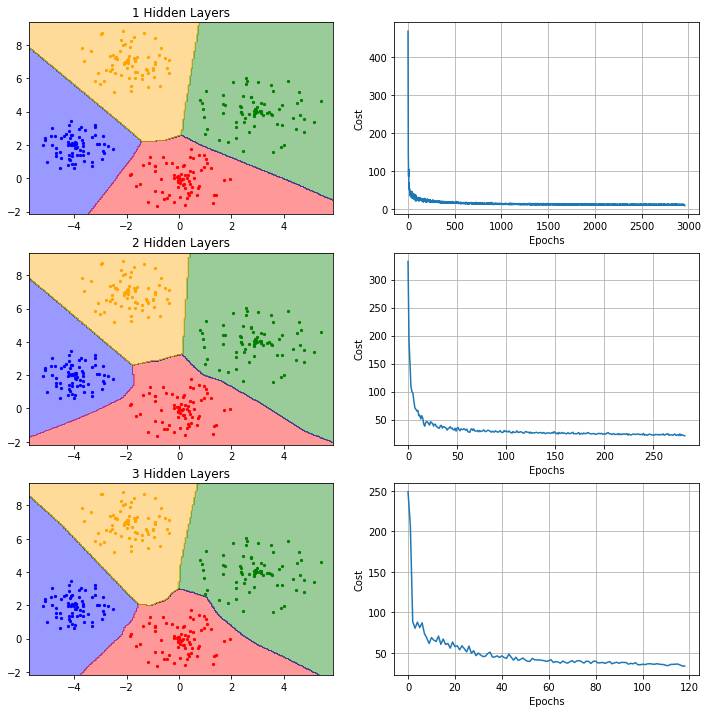

In [190]:
%matplotlib inline
from matplotlib import pyplot as plt

def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data

N = 300
data = np.concatenate([
    circle([0, 0], 2, N//4),
    circle([-4, 2], 1.5, N//4),
    circle([3, 4], 2.5, N//4),
    circle([-2, 7], 2, N//4)
])
labels = np.concatenate([
    np.full(N//4, 0),
    np.full(N//4, 1),
    np.full(N//4, 2),
    np.full(N//4, 3)
])

# 決定領域の描画
plt.figure(figsize=(12, 12))
for i in range(3):
    mlp = MLPClassifier(h_layers=i+1, h_units=11, epochs=10000, eta=0.001, n_batch=50, mode='relu')
    mlp.fit(data, labels)
    plt.subplot(3, 2, 2*i+1)
    plt.title('{} Hidden Layers'.format(i+1))
    # 決定領域描画のための自作関数
    plot(mlp, data, labels)
    plt.subplot(3, 2, 2*i+2)
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.plot(range(len(mlp.cost)), mlp.cost)
    plt.grid()
plt.show()

In [191]:
# デバッグモードで勾配チェック
for mode in ['sigmoid', 'tanh', 'relu']:
    print('---------- {} ----------'.format(mode))
    mlp = MLPClassifier(h_layers=5, h_units=4, epochs=10, eta=0.001, n_batch=50, mode=mode, debug_grad=True)
    mlp.fit(data, labels)
    for err in mlp.grad_relative_err:
        print(err)
"""
---------- sigmoid ----------
1.708272677515531e-10
2.027418758701553e-10
2.451406752832502e-10
1.9189998552274239e-10
5.362990167098542e-10
2.2162767947401422e-10
2.1582437673709201e-10
1.5802183663861842e-10
1.7465687767147363e-10
1.846231088602068e-10
---------- tanh ----------
1.4196503003915701e-10
2.0594401187231304e-10
1.2387032283326416e-10
1.7385200579246543e-10
1.4105502637182868e-10
2.0788099754750292e-10
1.1950114070604786e-10
2.2590206006465284e-10
2.718312158622659e-10
2.55476760420093e-10
---------- relu ----------
5.232138336195435e-11
7.072810694410954e-11
1.696426837940076e-10
8.328776176840156e-11
1.0290774341862765e-10
6.746778814094313e-11
5.591969851955688e-11
8.547132473256253e-11
1.3456819029690514e-10
1.173203010110926e-10
"""

---------- sigmoid ----------
1.708272677515531e-10
2.027418758701553e-10
2.451406752832502e-10
1.9189998552274239e-10
5.362990167098542e-10
2.2162767947401422e-10
2.1582437673709201e-10
1.5802183663861842e-10
1.7465687767147363e-10
1.846231088602068e-10
---------- tanh ----------
1.4196503003915701e-10
2.0594401187231304e-10
1.2387032283326416e-10
1.7385200579246543e-10
1.4105502637182868e-10
2.0788099754750292e-10
1.1950114070604786e-10
2.2590206006465284e-10
2.718312158622659e-10
2.55476760420093e-10
---------- relu ----------
5.232138336195435e-11
7.072810694410954e-11
1.696426837940076e-10
8.328776176840156e-11
1.0290774341862765e-10
6.746778814094313e-11
5.591969851955688e-11
8.547132473256253e-11
1.3456819029690514e-10
1.173203010110926e-10


'\n---------- sigmoid ----------\n1.0967296882891205e-10\n8.915222561651479e-11\n1.1242114709522408e-10\n9.318255833596633e-11\n9.377976925203862e-11\n1.5508572871099484e-10\n9.558475218745664e-11\n9.206073512054081e-11\n1.1497392032610063e-10\n1.2969323719412228e-10\n---------- tanh ----------\n1.2809222847746094e-10\n9.647004378237663e-11\n8.057312016284312e-11\n9.220345094360472e-11\n8.880294919795507e-11\n8.929958981384533e-11\n9.095496148789177e-11\n1.1350829348795615e-10\n1.8293224451067315e-10\n1.9007385280147202e-10\n---------- relu ----------\n5.706417795462251e-11\n4.5680533837054385e-11\n4.908781704869093e-11\n4.28095796613343e-11\n6.505915829352747e-11\n8.00233783635315e-11\n4.884472556692264e-11\n5.000483289154512e-11\n5.664131048226177e-11\n7.970452331539599e-11\n'

---------- sigmoid ----------


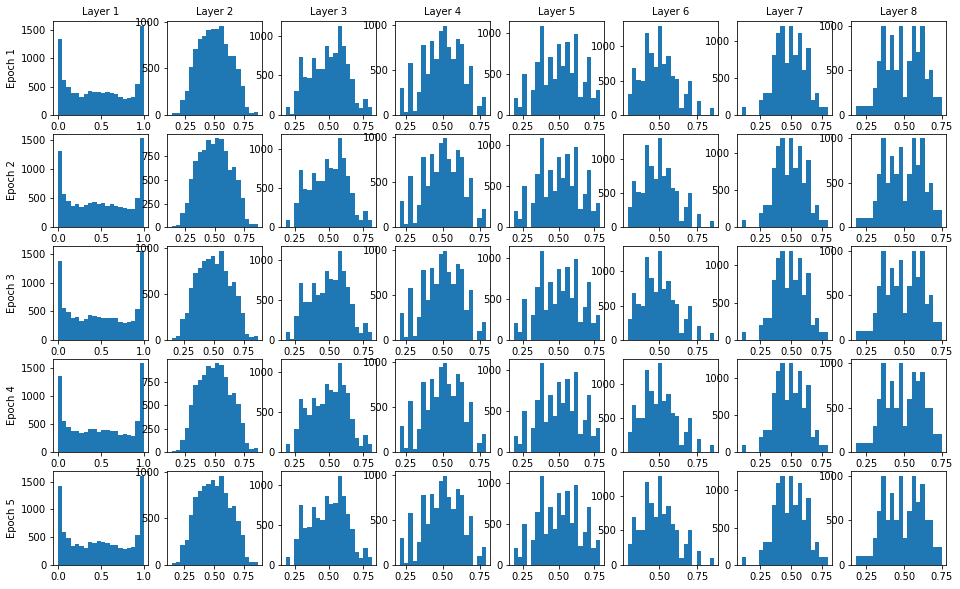

---------- tanh ----------


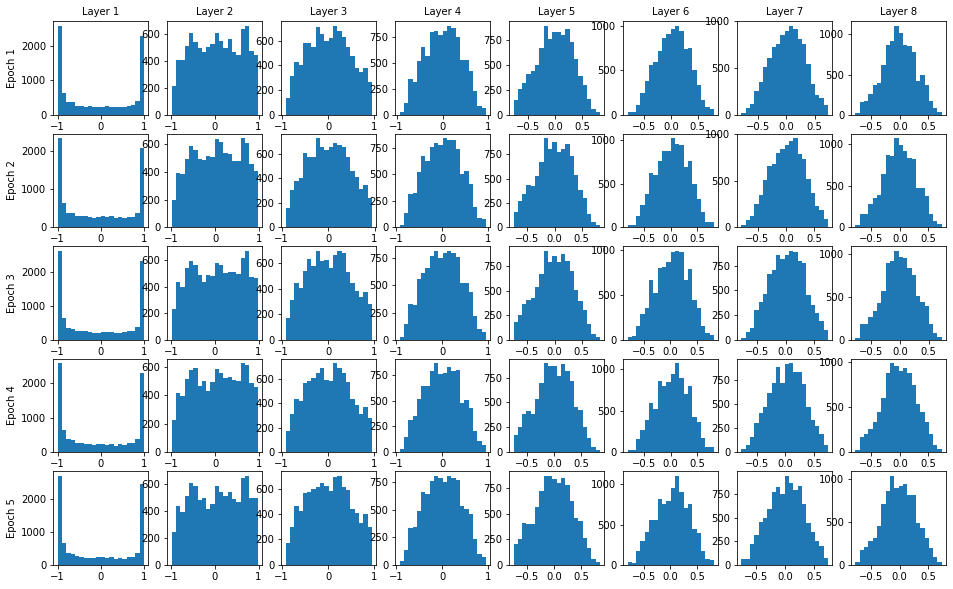

---------- relu ----------


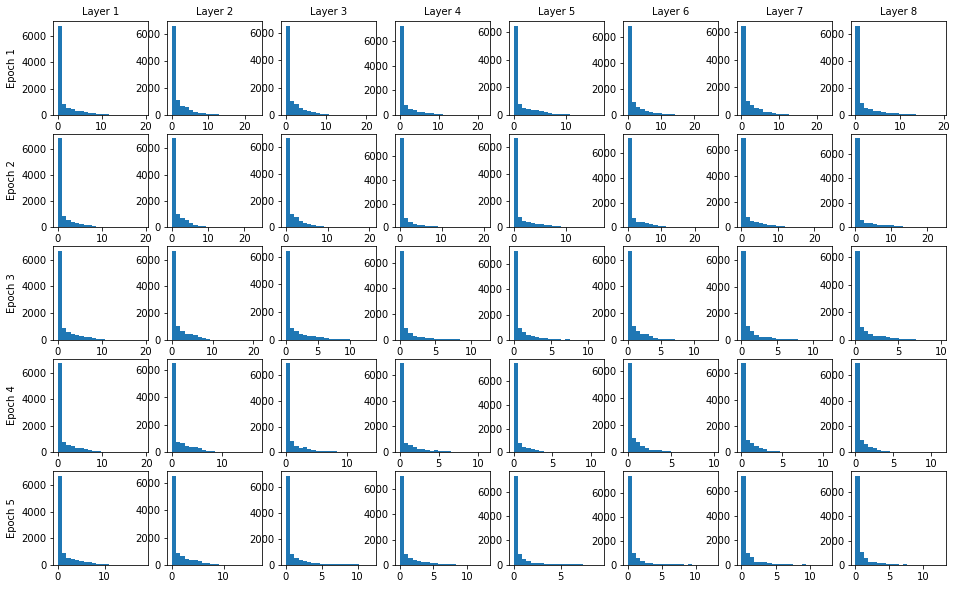

In [194]:
# デバッグモードで各層の出力値分布調査
for mode in ['sigmoid', 'tanh', 'relu']:
    print('---------- {} ----------'.format(mode))
    mlp = MLPClassifier(h_layers=8, h_units=100, epochs=5, eta=0.0001, n_batch=100, mode=mode, debug_activation_hist=True)
    mlp.fit(data, labels)
    n_epoch = len(mlp.A_hist)
    n_layer = len(mlp.A_hist[0])
    plt.figure(figsize=(2*n_layer, 2*n_epoch))
    for t in range(n_epoch):
        for l in range(n_layer):
            hist, bins = mlp.A_hist[t][l]
            width = (bins[-1] - bins[0]) / (len(bins)-1)
            bins = (bins[:-1] + bins[1:]) / 2.0
            plt.subplot(n_epoch, n_layer, t*n_layer+l+1)
            if t == 0:
                plt.title('Layer {}'.format(l+1), fontsize=10)
            if l == 0:
                plt.ylabel('Epoch {}'.format(t+1), fontsize=10)
            plt.bar(bins, hist, width=width)
    plt.show()

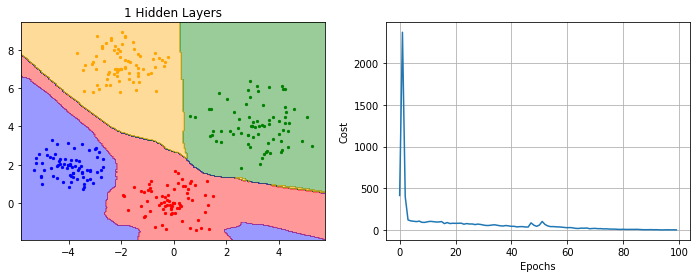

In [35]:
plt.figure(figsize=(12, 4))
mlp = MLPClassifier(h_layers=i+30, h_units=50, epochs=100, eta=0.0001, n_batch=50, mode='relu')
mlp.fit(data, labels)
plt.subplot(1, 2, 1)
plt.title('{} Hidden Layers'.format(i+1))
# 決定領域描画のための自作関数
plot(mlp, data, labels)
plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.plot(range(len(mlp.cost)), mlp.cost)
plt.grid()
plt.show()

# 理論

$$
\begin{eqnarray}
\end{eqnarray}
\cfrac{\partial}{\partial}
\displaystyle \sum_{i}^{k}
\boldsymbol{w}
$$

## 0. 準備

入力層を除く任意の第 $$l$$ 層を考える。

総出力の第 $$j$$ 成分 $$z_j^{(l)}$$、および活性化ユニット $$a_j^{(l)}$$ は、その層の重みと1つ前の層の活性化ユニットを用いて次のように計算される。

$$
\begin{eqnarray}
z_j^{(l)} &=& \displaystyle \sum_{k} w_{k \rightarrow j}^{(l)} a_k^{(l-1)} &\qquad\qquad& \rm{(0.1)} \\
a_j^{(l)} &=& \phi(z_j^{(l)}) &\qquad\qquad& \rm{(0.2)}
\end{eqnarray}
$$

最小化したいコスト関数（誤差平方和など）を $$J(W)$$ と置くと、第 $$l$$ 層の重みに対するコスト関数の勾配は以下のように計算できる。

$$
\begin{eqnarray}
\cfrac{\partial J(W)}{\partial w_{i \rightarrow j}^{(l)}}
&=& \displaystyle \sum_{k} \cfrac{\partial J(W)}{\partial z_k^{(l)}} \cfrac{\partial z_k^{(l)}}{\partial w_{i \rightarrow j}^{(l)}} \\
&=& \cfrac{\partial J(W)}{\partial z_j^{(l)}} \cfrac{\partial z_j^{(l)}}{\partial w_{i \rightarrow j}^{(l)}} \\
&=& \cfrac{\partial J(W)}{\partial z_j^{(l)}} a_i^{(l-1)} \\
\end{eqnarray}
$$

誤差

$$
\delta_j^{(l)} \equiv \cfrac{\partial J(W)}{\partial z_j^{(l)}} \qquad\qquad \rm{(0.3)}
$$

を定義すると、

$$
\cfrac{\partial J(W)}{\partial w_{i \rightarrow j}^{(l)}} = \delta_j^{(l)} a_i^{(l-1)} \qquad\qquad \rm{(0.4)}
$$

## 1. 出力層の重みの勾配

最終層（出力層）を第 $$L$$ 層とする。

$$
z_j^{(L)} = \displaystyle \sum_{k} w_{k \rightarrow j}^{(L)} a_k^{(L-1)}
$$

出力層の重みに関するコスト関数の勾配は

$$
\cfrac{\partial J(W)}{\partial w_{i \rightarrow j}^{(L)}}
= \delta_j^{(L)} a_i^{(L-1)} = \cfrac{\partial J(W)}{\partial z_j^{(L)}} a_i^{(L-1)} \qquad\qquad \rm{(1.1)}
$$

コスト関数 $$J(W)$$ は出力層の総出力 $$z_j^{(L)}$$ を使って計算するので、$$\cfrac{\partial J(W)}{\partial z_j^{(L)}}$$ の値は計算して求められる。


## 2. 隠れ層の重みの勾配

隠れ層である第 $$l$$ 層（$$l \lt L$$）の重みに関するコスト関数の勾配は、

$$
\cfrac{\partial J(W)}{\partial w_{i \rightarrow j}^{(l)}}
= \delta_j^{(l)} a_i^{(l-1)}
$$

$$\rm{(0.1), (0.2)}$$ を用いて誤差を計算する：

$$
\begin{eqnarray}
\delta_j^{(l)}
&=& \cfrac{\partial J(W)}{\partial z_j^{(l)}} \\
&=& \displaystyle \sum_{k} \cfrac{\partial J(W)}{\partial z_k^{(l+1)}} \cfrac{\partial z_k^{(l+1)}}{\partial z_j^{(l)}} \\
&=& \displaystyle \sum_{k} \delta_k^{(l+1)} \cfrac{\partial z_k^{(l+1)}}{\partial z_j^{(l)}} \\
&=& \displaystyle \sum_{k} \delta_k^{(l+1)}
\sum_i \cfrac{\partial z_k^{(l+1)}}{\partial a_i^{(l)}} \cfrac{\partial a_i^{(l)}}{\partial z_j^{(l)}} \\
&=& \displaystyle \sum_{k} \delta_k^{(l+1)}
\sum_i \cfrac{\partial z_k^{(l+1)}}{\partial a_i^{(l)}} \cfrac{\partial \phi\left(z_i^{(l)}\right)}{\partial z_j^{(l)}} \\
&=& \displaystyle \sum_{k} \delta_k^{(l+1)}
\cfrac{\partial z_k^{(l+1)}}{\partial a_j^{(l)}} \cfrac{\partial \phi\left(z_j^{(l)}\right)}{\partial z_j^{(l)}} \\
&=& \displaystyle \sum_{k} \delta_k^{(l+1)}
w_{j \rightarrow k}^{(l+1)} \cfrac{\partial \phi\left(z_j^{(l)}\right)}{\partial z_j^{(l)}} \\
&=& \cfrac{\partial \phi\left(z_j^{(l)}\right)}{\partial z_j^{(l)}} \left( \left(W^{(l+1)}\right)^T \boldsymbol{\delta}^{(l+1)} \right){}_j \\
\end{eqnarray}
$$

全ての成分をまとめてベクトル表記にすると、

$$
\begin{eqnarray}
\boldsymbol{\delta}^{(l)}
&=& \cfrac{\partial J(W)}{\partial \boldsymbol{z}^{(l)}} \\
&=& \cfrac{\partial \phi\left(z_j^{(l)}\right)}{\partial \boldsymbol{z}^{(l)}} \odot \left(W^{(l+1)}\right)^T \boldsymbol{\delta}^{(l+1)} \\
\end{eqnarray}
$$

※ $$\odot$$ は成分ごとに積を取る演算（アダマール積）。

したがって、1つ後ろの第 $$l+1$$ 層の誤差が分かれば第 $$l$$ 層の誤差も計算できる。

**前節で最終層（出力層）の誤差を計算済みであるから、再帰的に全ての誤差が計算できる。**


## 重みの更新

以上により、全ての重みに関するコスト関数の勾配が求まったので、

$$
W_{ij}^{(l)} \longleftarrow W_{ij}^{(l)} - \eta \cfrac{\partial J(W)}{\partial w_{i \rightarrow j}^{(l)}}
$$

により重みを更新する。

$$\eta$$ は学習率。

## 活性化関数

![活性化関数](https://user-images.githubusercontent.com/13412823/82826101-6fe2f400-9ee7-11ea-8282-7940a05b8c8d.png)

### シグモイド関数（ロジスティック関数）

$$
\phi(z_j) = \cfrac{1}{1 + e^{-z_j}}
$$

$$
\cfrac{\partial \phi(z_j)}{\partial z_j}
= \cfrac{e^{-z_j}}{(1 + e^{-z_j})^2}
= \phi(z_j)\left(1-\phi(z_j)\right)
$$

### 双曲線正接関数（ハイパボリックタンジェント）

$$
\phi(z_j) = \tanh(z_j) = \cfrac{e^{z_j} - e^{-z_j}}{e^{z_j} + e^{-z_j}}
$$

$$
\cfrac{\partial \phi(z_j)}{\partial z_j} = 
$$

### ReLU 関数（Rectified Linear Unit）

$$
\phi(z_j) = \begin{cases}
0 & (z_j \le 0) \\
z_j & (z_j \gt 0)
\end{cases}
$$

$$
\cfrac{\partial \phi(z_j)}{\partial z_j} = \begin{cases}
0 & (z_j \le 0) \\
1 & (z_j \gt 0)
\end{cases}
$$


### ソフトマックス関数

$$
\phi(z_j) = \cfrac{e^{z_j}}{\displaystyle \sum_k e^{z_k}}
$$

$$
\begin{eqnarray}
\cfrac{\partial \phi(z_i)}{\partial z_j}
&=& \begin{cases}
\cfrac{e^{z_j} \sum_k e^{z_k} - (e^{z_j})^2}{\left(\sum_k e^{z_k}\right)^2} & (i = j) \\
- \cfrac{e^{z_j} e^{z_i}}{\left(\sum_k e^{z_k}\right)^2} & (i = j) & (i \neq j)
\end{cases} \\
&=& \begin{cases}
\phi(z_j) \left( 1 - \phi(z_j) \right) & (i = j) \\
- \phi(z_i) \phi(z_j) & (i \neq j)
\end{cases} \\
\end{eqnarray}
$$

全ての $$j$$ で和を取ると1になることから、分類問題における各ラベルへの所属確率として、出力層の活性化関数に使うことが多い。



## 実装

多層パーセプトロンによる多クラス分類器を作ってみる。

### 準備

ロジスティック回帰と同様に、最小化すべきコスト関数 $$J(W)$$ は教師データが与えられたときにそれが実現する尤度（対数尤度）にマイナスをかけたものとする：

$$
J(W) =
- \displaystyle \sum_i \left\{
\sum_j y_j^{(i)} \log{\phi\left(z_j^{(L)(i)}\right)}
+ \sum_i \sum_j \left(1-y_j^{(i)}\right) \log{\left(1-\phi\left(z_j^{(L)(i)}\right)\right)}
\right\}
$$

- $$y_j^{(i)}$$: $$i$$ 番目のサンプルの正解ラベルベクトルの第 $$j$$ 成分
- $$z_j^{(L)(i)}$$: $$i$$ 番目のサンプルの出力層（第 $$L$$ 層）の全入力の第 $$j$$ 成分

隠れ層の活性化関数にはロジスティック関数 / 双曲線正接関数 / ReLU 関数を用い、出力層の活性化関数はソフトマックス関数を使う。

誤差逆伝播の過程で、出力層の総入力に関するコスト関数の微分を使うので計算しておく。

$$
\begin{eqnarray}
\delta_j^{(L)(i)} = \cfrac{\partial J(W)}{\partial z_j^{(L)(i)}}
&=&
- \cfrac{\partial}{\partial z_j^{(L)(i)}} \displaystyle \sum_k \left\{
\sum_l y_l^{(k)} \log{\phi\left(z_l^{(L)(k)}\right)}
+ \sum_k \sum_l \left(1-y_l^{(k)}\right) \log{\left(1-\phi\left(z_l^{(L)(k)}\right)\right)}
\right\}
\\
&=&
- \displaystyle \left\{
\sum_l y_l^{(i)} \cfrac{1}{\phi\left(z_l^{(L)(i)}\right)} \cfrac{\partial \phi\left(z_l^{(L)(i)}\right)}{\partial z_j^{(L)(i)}}
- \sum_l \left(1-y_l^{(i)}\right) \cfrac{1}{1-\phi\left(z_l^{(L)(i)}\right)} \cfrac{\partial \phi\left(z_l^{(L)(i)}\right)}{\partial z_j^{(L)(i)}}
\right\}
\\
&=&
\displaystyle \sum_l \cfrac{\phi\left(z_l^{(L)(i)}\right)-y_l^{(i)}}{\phi\left(z_l^{(L)(i)}\right) \left(1-\phi\left(z_l^{(L)(i)}\right)\right)}
\cfrac{\partial \phi\left(z_l^{(L)(i)}\right)}{\partial z_j^{(L)(i)}}
\\
&=&
\cfrac{\phi\left(z_j^{(L)(i)}\right)-y_j^{(i)}}{1-\phi\left(z_j^{(L)(i)}\right)} \left(1-\phi\left(z_j^{(L)(i)}\right)\right)
- \displaystyle \sum_{l \neq j} \cfrac{\phi\left(z_l^{(L)(i)}\right)-y_l^{(i)}}{1-\phi\left(z_l^{(L)(i)}\right)} \phi\left(z_j^{(L)(i)}\right)
\\
&=&
\cfrac{\phi\left(z_j^{(L)(i)}\right)-y_j^{(i)}} {1 - \phi\left(z_j^{(L)(i)}\right)}
- \phi\left(z_j^{(L)(i)}\right) \displaystyle \sum_l \cfrac{\phi\left(z_l^{(L)(i)}\right)-y_l^{(i)}}{1-\phi\left(z_l^{(L)(i)}\right)}
\end{eqnarray}
$$

途中、ソフトマックス関数の微分の式を用いて和を $$i=j$$ と $$i \neq j$$ に分けた。

正則化を行う場合、正則化項の微分

$$
\cfrac{\partial}{\partial w_{i \rightarrow j}^{(l)}} \left( \cfrac{\lambda}{2} \displaystyle \sum_{i^{'}} \sum_{j^{'}} \sum_{l^{'}} \left(w_{i^{'} \rightarrow j^{'}}^{(l^{'})}\right)^2 \right)
= \lambda w_{i \rightarrow j}^{(l)}
$$

をコスト関数の勾配に加える。

# 勾配消失



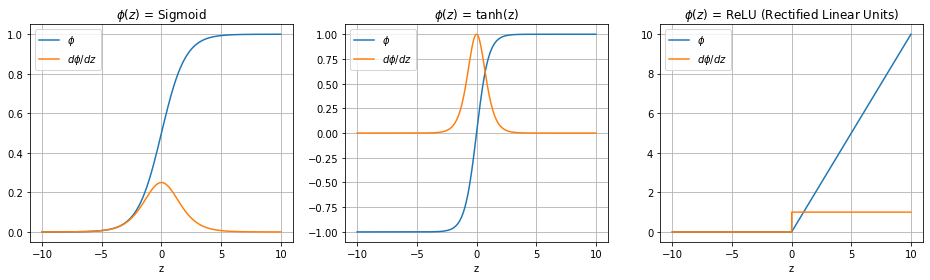

In [152]:
x = np.arange(-10, 10, 0.01)

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
y1 = 1 / (1 + np.exp(-x))
y2 = y1 * (1 - y1)
plt.title('$\phi(z)$ = Sigmoid')
plt.plot(x, y1, label='$\phi$')
plt.plot(x, y2, label='$d\phi / dz$')
plt.xlabel('z')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
y1 = np.tanh(x)
y2 = 1/np.cosh(x)**2
plt.title('$\phi(z)$ = tanh(z)')
plt.plot(x, y1, label='$\phi$')
plt.plot(x, y2, label='$d\phi / dz$')
plt.xlabel('z')
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
y1 = np.zeros(x.shape)
y2 = np.zeros(x.shape)
for i in range(len(x)):
    if x[i] >= 0:
        y1[i] = x[i]
        y2[i] = 1
plt.title('$\phi(z)$ = ReLU (Rectified Linear Units)')
plt.plot(x, y1, label='$\phi$')
plt.plot(x, y2, label='$d\phi / dz$')
plt.xlabel('z')
plt.legend()
plt.grid()

plt.show()

In [14]:
import numpy as np

class MLPClassifierTmp:
    """
    多層パーセプトロン（MLP）による分類器
    活性化関数にはシグモイド関数を用いる
    
    Attributes
    ----------
    h_layers : int
        隠れ層の数
    h_units : int
        隠れ層のユニットの個数（バイアスを除く）
    epochs : int
        繰り返し回数
    eta : float
        学習率
    n_batch : int
        ミニバッチ学習のバッチサイズ
    debug : bool
        デバッグモードか否か
        True の場合は勾配チェックを行う
    n : int
        教師データの件数
    m : inti
        入力の次元
    t : int
        分類ラベルの種類数
    W : list[numpy array]
        入力層 -> 隠れ層の重み (h x (m+1))
        隠れ層 -> 隠れ層の重み (h x (h+1))
        隠れ層 -> 出力層の重み (t x (h+1))
    mse : list[float]
        エポック毎の平均二乗誤差（Mean Squared Errors）を格納するリスト
    """
    def __init__(self, h_layers, h_units, epochs, eta, n_batch, debug=False):
        self.h_layers = h_layers
        self.h_units = h_units
        self.epochs = epochs
        self.eta = eta
        self.n_batch = n_batch
        self.debug = debug
    
    def fit(self, data, labels):
        
        self.grads = None
        
        
        self.index2label = np.unique(labels)
        self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        self.n = len(data)
        self.m = len(data[0])
        self.t = len(self.index2label)
        self.W = []
        self.W.append(np.random.rand(self.h_units, self.m+1))
        for i in range(self.h_layers-1):
            self.W.append(np.random.rand(self.h_units, self.h_units+1))
        self.W.append(np.random.rand(self.t, self.h_units+1))
        X = np.full([self.m+1, self.n], 1.0)
        X[1:] = data.T
        Y = np.zeros([self.t, self.n])
        for i in range(self.n):
            l = labels[i]
            Y[self.label2index[l]][i] = 1.0
        
        self.mse = []
        for _ in range(self.epochs):
            # ミニバッチ法による学習
            ids = np.random.choice(range(self.n), self.n_batch, replace=False)
            X_part = X[:, ids]
            Y_part = Y[:, ids]
            A = self.__forward_prop(X_part, self.W)
            mse = np.sum((Y_part - A[-1])**2) / self.n_batch
            self.mse.append(mse)
            if mse < 0.001:
                break
            self.__back_prop(A, X_part, Y_part)
        return
        
    def predict(self, d):
        """
        Parameters
        ----------
        d : 予測したいデータ
        """
        x = np.full(len(d)+1, 1.0)
        x[1:] = d
        y = self.__forward_prop(x.reshape(-1,1), self.W)[-1]
        i_label = np.argmax(y)
        return self.index2label[i_label]
    
    def __forward_prop(self, X, W):
        """
        順伝播法により各層の出力を計算
        """
        n = len(X[0])
        A = [X]
        for i in range(self.h_layers):
            Z = np.dot(W[i], A[i])
            A.append(np.full([self.h_units+1, n], 1.0))
            A[-1][1:] = self.__sigmoid(Z)
        Z = np.dot(W[-1], A[-1])
        A.append(self.__sigmoid(Z))
        return A
    
    def __back_prop(self, A, X, Y):
        """
        誤差逆伝播法により重みを更新
        """
        d = A[-1] - Y
        grad = [np.dot(d, A[-2].T)]
        for i in range(1, self.h_layers+1):
            d = np.dot(self.W[-i].T[1:], d) * A[-i-1][1:] * (1-A[-i-1][1:])
            grad.append(np.dot(d, A[-i-2].T))
        grad.reverse()
        if self.debug:
            self.__gradient_check(X, Y, self.W, grad)
        for i in range(self.h_layers+1):
            self.W[i] -= self.eta * grad[i]
        
        if self.grads is None:
            self.grads = []
            for g in grad:
                self.grads.append(np.average(np.abs(g)))
        
        return
        
    def __sigmoid(self, z):
        """
        Parameters
        ----------
        Z : numpy array
            総入力の配列
        """
        return 1.0 / (1.0 + np.exp(-z))
    
    def __gradient_check(self, X, Y, W, grad):
        """
        デバッグ用のメソッド
        数値的に求めた勾配と解析的に求めた勾配を比べる
        相対誤差（relative_err）が小さい（ゼロに近い）ほど良い
        """
        ep = 1e-5
        num_grad = []
        for i in range(len(W)):
            g = np.zeros(W[i].shape)
            ep_arr = np.zeros(W[i].shape)
            for j in range(W[i].shape[0]):
                for k in range(W[i].shape[1]):
                    ep_arr[j][k] = ep
                    W_ = [np.copy(w) for w in W]
                    W_[i] += ep_arr
                    A = self.__forward_prop(X, W_)
                    cost1 = self.__cost(Y, A[-1])
                    W_ = [np.copy(w) for w in W]
                    W_[i] -= ep_arr
                    A = self.__forward_prop(X, W_)
                    cost2 = self.__cost(Y, A[-1])
                    g[j][k] = (cost1-cost2)/ep/2.0
                    ep_arr[j][k] = 0
            num_grad.append(g)
        v_num_grad= np.hstack(tuple([g.flatten() for g in num_grad]))
        v_grad = np.hstack(tuple([g.flatten() for g in grad]))
        relative_err = np.linalg.norm(v_num_grad-v_grad) / (np.linalg.norm(v_num_grad) + np.linalg.norm(v_grad))
        print(relative_err)
    
    def __cost(self, y, output):
        """
        コスト関数の計算（ロジスティック回帰と同じ対数尤度にマイナスをかけたもの）
        """
        cost = np.sum(-y * np.log((output)) - (1.0-y) * np.log(1.0-output))
        return cost


class MLPClassifierReLU:
    """
    多層パーセプトロン（MLP）による分類器
    活性化関数にはシグモイド関数を用いる
    
    Attributes
    ----------
    h_layers : int
        隠れ層の数
    h_units : int
        隠れ層のユニットの個数（バイアスを除く）
    epochs : int
        繰り返し回数
    eta : float
        学習率
    n_batch : int
        ミニバッチ学習のバッチサイズ
    debug : bool
        デバッグモードか否か
        True の場合は勾配チェックを行う
    n : int
        教師データの件数
    m : inti
        入力の次元
    t : int
        分類ラベルの種類数
    W : list[numpy array]
        入力層 -> 隠れ層の重み (h x (m+1))
        隠れ層 -> 隠れ層の重み (h x (h+1))
        隠れ層 -> 出力層の重み (t x (h+1))
    mse : list[float]
        エポック毎の平均二乗誤差（Mean Squared Errors）を格納するリスト
    """
    def __init__(self, h_layers, h_units, epochs, eta, n_batch, debug=False):
        self.h_layers = h_layers
        self.h_units = h_units
        self.epochs = epochs
        self.eta = eta
        self.n_batch = n_batch
        self.debug = debug
    
    def fit(self, data, labels):
        
        self.grads = None
        
        
        self.index2label = np.unique(labels)
        self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        self.n = len(data)
        self.m = len(data[0])
        self.t = len(self.index2label)
        self.W = []
        self.W.append(np.random.randn(self.h_units, self.m+1)*np.sqrt(2.0/self.h_units))
        for i in range(self.h_layers-1):
            self.W.append(np.random.randn(self.h_units, self.h_units+1)*np.sqrt(2.0/self.h_units))
        self.W.append(np.random.randn(self.t, self.h_units+1)*np.sqrt(2.0/self.t))
        X = np.full([self.m+1, self.n], 1.0)
        X[1:] = data.T
        Y = np.zeros([self.t, self.n])
        for i in range(self.n):
            l = labels[i]
            Y[self.label2index[l]][i] = 1.0
        
        self.mse = []
        for _ in range(self.epochs):
            # ミニバッチ法による学習
            ids = np.random.choice(range(self.n), self.n_batch, replace=False)
            X_part = X[:, ids]
            Y_part = Y[:, ids]
            A = self.__forward_prop(X_part, self.W)
            mse = np.sum((Y_part - A[-1])**2) / self.n_batch
            self.mse.append(mse)
            if mse < 0.01:
                break
            self.__back_prop(A, X_part, Y_part)
        return
        
    def predict(self, d):
        """
        Parameters
        ----------
        d : 予測したいデータ
        """
        x = np.full(len(d)+1, 1.0)
        x[1:] = d
        y = self.__forward_prop(x.reshape(-1,1), self.W)[-1]
        i_label = np.argmax(y)
        return self.index2label[i_label]
    
    def __forward_prop(self, X, W):
        """
        順伝播法により各層の出力を計算
        """
        n = len(X[0])
        A = [X]
        for i in range(self.h_layers):
            Z = np.dot(W[i], A[i])
            A.append(np.full([self.h_units+1, n], 1.0))
            A[-1][1:] = self.__sigmoid(Z)
        Z = np.dot(W[-1], A[-1])
        A.append(self.__sigmoid(Z))
        return A
    
    def __back_prop(self, A, X, Y):
        """
        誤差逆伝播法により重みを更新
        """
        d = A[-1] - Y
        grad = [np.dot(d, A[-2].T)]
        for i in range(1, self.h_layers+1):
            d = np.dot(self.W[-i].T[1:], d) * self.__grad(A[-i-1][1:])
            grad.append(np.dot(d, A[-i-2].T))
        grad.reverse()
        if self.debug:
            self.__gradient_check(X, Y, self.W, grad)
        for i in range(self.h_layers+1):
            self.W[i] -= self.eta * grad[i]
        
        if self.grads is None:
            self.grads = []
            for g in grad:
                self.grads.append(np.average(np.abs(g)))
        
        return
        
    def __sigmoid(self, z):
        """
        Parameters
        ----------
        Z : numpy array
            総入力の配列
        """
        R = np.zeros(z.shape)
        for i in range(z.shape[0]):
            for j in range(z.shape[1]):
                R[i][j] = z[i][j] if z[i][j] > 0 else 0
        return R
    
    def __grad(self, A):
        R = np.zeros(A.shape)
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                R[i][j] = 1 if A[i][j] > 0 else 0
        return R
    
    def __gradient_check(self, X, Y, W, grad):
        """
        デバッグ用のメソッド
        数値的に求めた勾配と解析的に求めた勾配を比べる
        相対誤差（relative_err）が小さい（ゼロに近い）ほど良い
        """
        ep = 1e-5
        num_grad = []
        for i in range(len(W)):
            g = np.zeros(W[i].shape)
            ep_arr = np.zeros(W[i].shape)
            for j in range(W[i].shape[0]):
                for k in range(W[i].shape[1]):
                    ep_arr[j][k] = ep
                    W_ = [np.copy(w) for w in W]
                    W_[i] += ep_arr
                    A = self.__forward_prop(X, W_)
                    cost1 = self.__cost(Y, A[-1])
                    W_ = [np.copy(w) for w in W]
                    W_[i] -= ep_arr
                    A = self.__forward_prop(X, W_)
                    cost2 = self.__cost(Y, A[-1])
                    g[j][k] = (cost1-cost2)/ep/2.0
                    ep_arr[j][k] = 0
            num_grad.append(g)
        v_num_grad= np.hstack(tuple([g.flatten() for g in num_grad]))
        v_grad = np.hstack(tuple([g.flatten() for g in grad]))
        relative_err = np.linalg.norm(v_num_grad-v_grad) / (np.linalg.norm(v_num_grad) + np.linalg.norm(v_grad))
        print(relative_err)
    
    def __cost(self, y, output):
        """
        コスト関数の計算（ロジスティック回帰と同じ対数尤度にマイナスをかけたもの）
        """
        cost = np.sum(-y * np.log((output)) - (1.0-y) * np.log(1.0-output))
        return cost

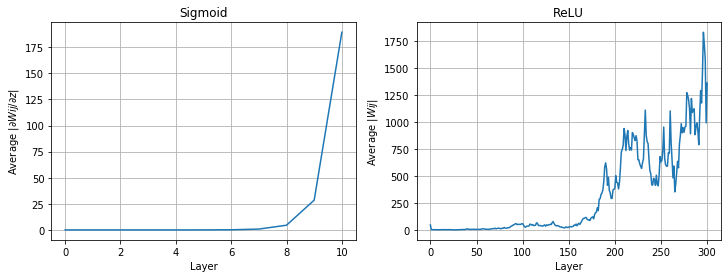

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data

N = 300
data = np.concatenate([
    circle([0, 0], 2, N//4),
    circle([-4, 2], 1.5, N//4),
    circle([3, 4], 2.5, N//4),
    circle([-2, 7], 2, N//4)
])
labels = np.concatenate([
    np.full(N//4, 0),
    np.full(N//4, 1),
    np.full(N//4, 2),
    np.full(N//4, 3)
])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Sigmoid')
plt.xlabel('Layer')
plt.ylabel('Average $|\partial Wij / \partial z|$')
mlp = MLPClassifierTmp(h_layers=10, h_units=4, epochs=1, eta=0.01, n_batch=N)
mlp.fit(data, labels)
plt.plot(range(len(mlp.grads)), mlp.grads)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('ReLU')
plt.xlabel('Layer')
plt.ylabel('Average $|Wij|$')
mlp = MLPClassifierReLU(h_layers=300, h_units=100, epochs=1, eta=1e-4, n_batch=N)
mlp.fit(data, labels)
plt.plot(range(len(mlp.grads)), mlp.grads)
plt.grid()
plt.show()

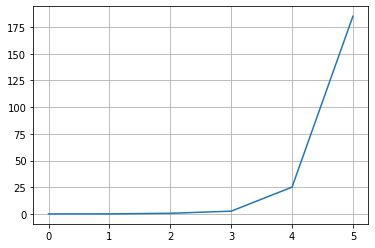

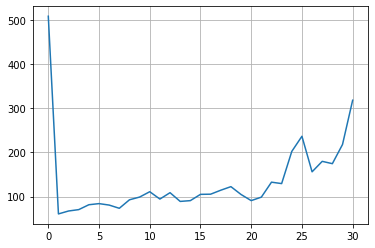

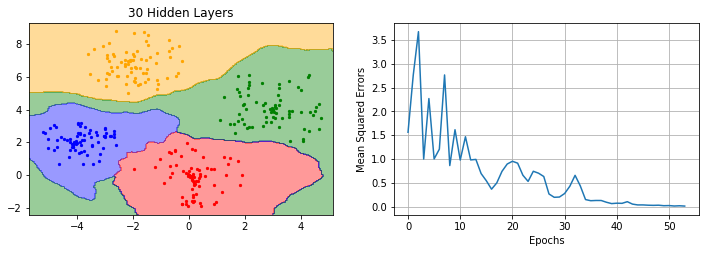

In [65]:
plt.figure(figsize=(12, 12))
mlp = MLPClassifierReLU(h_layers=30, h_units=100, epochs=100, eta=1e-4, n_batch=50)
mlp.fit(data, labels)
plt.subplot(3, 2, 1)
plt.title('{} Hidden Layers'.format(30))
# 決定領域描画のための自作関数
plot(mlp, data, labels)
plt.subplot(3, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Errors')
plt.plot(range(len(mlp.mse)), mlp.mse)
plt.grid()
plt.show()